In [565]:
import numpy as np

from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift


def freq_stacking(
    rx_subpulses, ref_subpulses, fc_RF_freqs, BW_RF_array, Bs_array, Fs_baseband
):
    """[summary] returns the D_f and d_t

    Args:
        rx_subpulses ([type] 2D array): [description] each row is a rx subpulse at baseband
        ref_subpulses ([type]2D array): [description] each row is a ref subpulse at baseband
        fc_RF_freqs ([type] 1D array): [description] center freqs of each RF subpulse in Hz
        BW_RF_array ([type] 1D array): [description] BWs of each RF subpulse in Hz
        Bs_array ([type] 1D array): [description] BWs of the baseband filter for each subpulse in Hz
        Fs_baseband ([type] real number): [description] sampling freq. of the baseband signal

    Returns:
        D_f, d_t [type] 1D array: [description] the compresses SWW in freq. domain and time domain
    """

    # do some sanity check
    if np.any(BW_RF_array > Fs_baseband):
        raise Exception("Subpulse BW is larger than Fs_baseband!")
    
    

    # compute the parameters of the RF_sww
    f_RF_sww_center, BW_RF_sww = compute_para_for_RF_sww(fc_RF_freqs, BW_RF_array)
    Fs_SWW = BW_RF_sww  # sampling freq of SWW at baseband
    fcn_array = (
        fc_RF_freqs - f_RF_sww_center
    )  # relative center freq. of each baseband subpulse

    if Fs_SWW < Fs_baseband:
        print(f'Fs_SWW = {Fs_SWW}')
        print(f'Fs_baseband = {Fs_baseband}')
        raise Exception("Fs_SWW need to be larger than Fs_baseband for correct up-sampling operation")


    Nup_actual = compute_Nup_f(rx_subpulses[0], Fs_baseband, Fs_SWW)
    D_f = np.zeros(int(Nup_actual), dtype=rx_subpulses[0].dtype)

    for ref_subpulse, rx_subpulse, Bs, fcn_baseband in zip(
        rx_subpulses, ref_subpulses, Bs_array, fcn_array
    ):
        Dn_f_read_for_stacking = process_one_baseband_subpulse(
            ref_subpulse, rx_subpulse, Bs, Fs_baseband, fcn_baseband, Fs_SWW
        )
        D_f = D_f + Dn_f_read_for_stacking

    D_f = np.conj(D_f) # to make the matlab result equal to to python result
    d_t = ifftshift(ifft(D_f))
    return D_f, d_t


# freq. stacking alg. helper functions
def compute_para_for_RF_sww(fc_RF_freqs, BW_RF_array):
    """[summary]

    Args:
        fc_RF_freqs ([type] 1-D array): [description] RF center frequencies of each RF subpulse
        BW_RF_array ([type] 1-D array): [description] bandwidths of each RF subpulse

    Returns:
        RF_sww_center, BW_RF_sww [type 1-D arrays]: [description] RF_sww center freq and its BW
    """

    # compute min freqs and max freq
    min_freqs = fc_RF_freqs - BW_RF_array / 2
    max_freqs = fc_RF_freqs + BW_RF_array / 2

    f_RF_sww_min = np.min(min_freqs)
    f_RF_sww_max = np.max(max_freqs)

    f_RF_sww_center = (f_RF_sww_min + f_RF_sww_max) / 2
    BW_RF_sww = f_RF_sww_max - f_RF_sww_min

    return f_RF_sww_center, BW_RF_sww


def compute_Nup_f(rx_subpulse, Fs_baseband, Fs_SWW):
    """[summary] Compute Nup: the number of data in D_f

    Args:
        rx_subpulse ([type] 1-D array): [description] any received baseband subpulse
        Fs_baseband ([type] real value): [description]
        Fs_SWW ([type] real value): [description]

    Returns:
        [type]: [description]
    """
    N = rx_subpulse.size
    Nup = Fs_SWW / Fs_baseband * N
    num_zeros_padding = np.ceil((Nup - N) / 2)
    Nup_actual = num_zeros_padding + N + num_zeros_padding
    return Nup_actual


# helper functions
def process_one_baseband_subpulse(
    ref_subpulse, rx_subpulse, Bs, Fs_baseband, fcn_baseband, Fs_SWW
):
    """This function implement the freq. stacking alg. for one subpulse:
        step1: doing matched filtering in freq. domain
        step2: filter the Dn_f at baseband
        step3, 4: up-sampling Dn_f and shift Dn_f to its corresponding center freq.

    Args:
        ref_subpulse ([type] 1-D array): [description] the baseband reference signal in time domain
        rx_subpulse ([type] 1-D array): [description] the baseband rx signal from channel in time domain
        Bs ([type] real value): [description] the baseband filter bandwidth
        Fs_baseband ([type] real value): [description] the sampling frequency of the baseband signal
        fcn_baseband ([type] real value): [description] the relative center frequency of the subpulse at baseband
        Fs_SWW ([type] real value): [description] the sampling frequency of the SWW at baseband
        

    Returns:
        Dn_f_read_for_stacking [type] 1-D array: [description] the filtered, up-sampled and freq. shifted Dn_f that is
        ready for stacking.
    """
    # step 1 of alg. 1
    RX_SUBPULSE = fft(rx_subpulse)
    REF_SUBPULSE = fft(ref_subpulse)
    Dn_f = RX_SUBPULSE * np.conj(REF_SUBPULSE)

    # step 2 of alg. 1: filter the Dn_f at baseband

    N = Dn_f.size
    freqs = fftfreq(N, 1 / Fs_baseband)
    freqs = fftshift(freqs)  # shift zero freq to center

    shifted_Dn_f = fftshift(Dn_f)
    Dn_f_filtered = np.zeros_like(shifted_Dn_f)

    Dn_f_filtered[(freqs > -Bs / 2) & (freqs < Bs / 2)] = shifted_Dn_f[
        (freqs > -Bs / 2) & (freqs < Bs / 2)
    ]

    # step 3 and 4: upsampling and freq shift
    Nup = Fs_SWW / Fs_baseband * N
    num_zeros_padding = np.ceil((Nup - N) / 2)
    Dn_f_up_sampled = np.concatenate(
        (np.zeros(int(num_zeros_padding), dtype=Dn_f_filtered.dtype), Dn_f_filtered, np.zeros(int(num_zeros_padding), dtype=Dn_f_filtered.dtype))
    )

    df = Fs_SWW / Nup
    num_shift = np.round(fcn_baseband / df)

    
    Dn_f_read_for_stacking = np.roll(Dn_f_up_sampled, int(num_shift))

    return Dn_f_read_for_stacking


In [566]:
def baseband_chirp_generation(Bi, Ti, Fs_baseband):
    """Bi: bandwidth of the chirp
    Ti: duration of the chirp
    Usually: Ti * Bi >= 5
    Fs_baseband: sample frequency of the baseband
    """
    Ts_baseband = 1 / Fs_baseband
    K = Bi / Ti
    t = np.arange(-Ti / 2, Ti / 2, Ts_baseband)
    baseband_chirp = np.exp(1j * np.pi * K * t ** 2)
    return baseband_chirp


def ref_subpulse_generation(w_t_i, phi_e_i, time_window_size, Fs_baseband):
    Ts_baseband = 1 / Fs_baseband
    num_zeros = np.round(time_window_size / Ts_baseband) - w_t_i.size
    ref_subpulse = np.concatenate(
        (w_t_i, np.zeros(int(num_zeros), dtype=w_t_i.dtype))
    ) * np.exp(1j * phi_e_i)
    return ref_subpulse


def rx_subpulse_generation(
    w_t_i, fci, phi_e_i, delay_time, time_window_size, Fs_baseband
):
    Ts_baseband = 1 / Fs_baseband
    num_delay = np.round(delay_time / Ts_baseband)
    num_pending_zeros = (
        np.round(time_window_size / Ts_baseband) - w_t_i.size - num_delay
    )
    delayed_w_t_i = np.concatenate(
        (
            np.zeros(int(num_delay), dtype=w_t_i.dtype),
            w_t_i,
            np.zeros(int(num_pending_zeros), dtype=w_t_i.dtype),
        )
    )

    rx_subpulse = (
        delayed_w_t_i
        * np.exp(-1j * 2 * np.pi * fci * delay_time)
        * np.exp(1j * phi_e_i)
    )
    return rx_subpulse


In [567]:
# define simulation parameters
Fs_baseband = 20e6
Ts_baseband = 1/Fs_baseband

chirp_rate = 50e6/10e-6 # using a fixed chirp rate for testing

max_subpulse_duration = Fs_baseband / chirp_rate
max_delay_time = 5e-6
time_window_size = 10 * max_subpulse_duration + max_delay_time  # this should be the rx buffer size, making it larger


delay_time = 0e-6 # set the delay time to be zero, b/c we want to find the ACF


In [568]:
# define the RF subpulses parameters: make sure the Fs_SWW is larger than Fs_baseband



#fc_RF_freqs = 500e6 + np.arange(50) * Fs_baseband
# fc_RF_freqs = np.random.uniform(low=500e6, high=1.5e9, size=(61,))
# fc_RF_freqs = np.linspace(500e6 - 10e6, 1.5e9 + 10e6, 61)
fc_RF_freqs = np.array([5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08, 5.00e+08,
        5.00e+08, 1.48e+09])
# BW_RF_array = Fs_baseband * np.ones_like(fc_RF_freqs)

BW_RF_array = np.array([1.80e+07, 1.80e+07, 1.80e+07, 1.80e+07, 1.80e+07, 2.00e+07,
        1.80e+07, 2.00e+07, 1.80e+07, 2.00e+07, 2.00e+07, 1.80e+07,
        1.80e+07, 1.80e+07, 1.80e+07, 1.80e+07, 1.80e+07, 2.00e+07,
        2.00e+07, 1.80e+07, 2.00e+07, 1.80e+07, 1.80e+07, 2.00e+07,
        2.00e+07, 2.00e+07, 2.00e+07, 2.00e+07, 1.80e+07, 1.80e+07,
        2.00e+07, 2.00e+07, 2.00e+07, 1.80e+07, 1.80e+07, 2.00e+07,
        1.80e+07, 1.80e+07, 2.00e+07, 2.00e+07, 1.80e+07, 1.80e+07,
        2.00e+07, 1.80e+07, 2.00e+07, 2.00e+07, 1.80e+07, 1.80e+07,
        1.80e+07, 2.00e+07])


In [569]:
def generate_LFM_rx_ref_subpulses_for_ACF(BW_RF_array, chirp_rate, time_window_size, Fs_baseband):
    """[summary]

    Args:
        BW_RF_array ([type] 1D array): [description]
        chirp_rate ([type] real number): [description]
        time_window_size ([type] real number): [description] receiver window size in sec
        Fs_baseband ([type] real number): [description] baseband samp freq in Hz

    Returns:
        [type] Two 2D numpy arrays: [description] LFM_rx_subpulses, LFM_ref_subpulses with the same chirp rate
    """    

    pulse_durations = BW_RF_array / chirp_rate # pulse durations of each LFM signal
    
    LFM_rx_subpulses = []
    LFM_ref_subpulses = []

    for Bi, Ti in zip(BW_RF_array, pulse_durations):
        w_t_i = baseband_chirp_generation(Bi, Ti, Fs_baseband) # generate the baseband signal

        rx_subpulse_i = rx_subpulse_generation(w_t_i, 0, 0, 0, time_window_size, Fs_baseband)
        ref_subpulse_i = ref_subpulse_generation(w_t_i, 0, time_window_size, Fs_baseband)

        LFM_rx_subpulses.append(rx_subpulse_i)
        LFM_ref_subpulses.append(ref_subpulse_i)


    LFM_rx_subpulses = np.array(LFM_rx_subpulses)
    LFM_ref_subpulses = np.array(LFM_ref_subpulses)

    return LFM_rx_subpulses, LFM_ref_subpulses



In [570]:
LFM_rx_subpulses, LFM_ref_subpulses = generate_LFM_rx_ref_subpulses_for_ACF(BW_RF_array, chirp_rate, time_window_size, Fs_baseband)

In [571]:
# filter BWs
Bs_array = BW_RF_array

In [572]:
# apply freq. stacking
D_f, d_t = freq_stacking(
    LFM_rx_subpulses, LFM_ref_subpulses, fc_RF_freqs, BW_RF_array, Bs_array, Fs_baseband
)

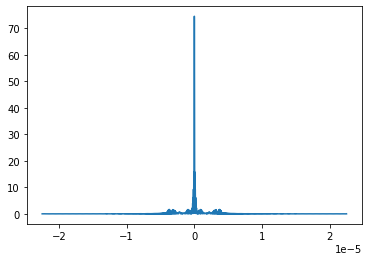

In [573]:
from matplotlib import pyplot as plt
%matplotlib inline

f_RF_sww_center, Fs_SWW = compute_para_for_RF_sww(fc_RF_freqs, BW_RF_array)
n = d_t.size
t = ( np.arange(0, n) - n/2 ) * 1/Fs_SWW

norm_factor = max(abs(d_t))
plt.plot(t, (abs(d_t) ))

plt.show()

In [574]:
# plot normalized d_t in db
import plotly.graph_objects as go

norm_factor = max(abs(d_t))
y = 20*np.log10(abs(d_t[d_t != 0]) / norm_factor )

fig = go.Figure()  # create a figure
fig.add_trace(
    go.Scatter(x=t, y=y, mode="lines")
)  # the name attribute is the legend


In [575]:
# test pulsewidth measurement: seems working good
import scipy.signal

def measure_ACF_pulse_width(dt, samp_freq):
    ACF = np.abs(dt)
    peaks = np.argmax(ACF)
    peaks = np.array([peaks])

    results = scipy.signal.peak_widths(ACF, peaks, rel_height=0.5)
    return results[0][0] * 1/samp_freq

pulse_width = measure_ACF_pulse_width(np.abs(d_t), Fs_SWW)
pulse_width, 1/Fs_SWW

(6.418177120928158e-08, 1e-09)

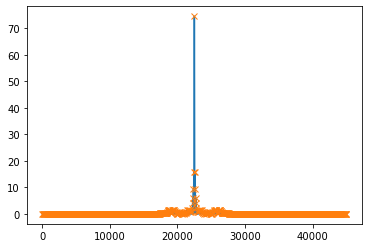

In [576]:
# find peaks
from scipy.signal import find_peaks
ACF = np.abs(d_t)
peaks, _ = find_peaks(ACF, height=0)
plt.plot(ACF)
plt.plot(peaks, ACF[peaks], "x")
plt.show()


In [577]:
# output matlab data for test
# import scipy.io

# scipy.io.savemat('D_py.mat', {"D_f_py": D_f, "d_t_py": d_t})

In [578]:
def peak_sidelobe_level(ACF):
    """[summary]

    Args:
        ACF ([type]): [description] ACF = np.abs(d_t)
    """
    ACF_sorted = np.sort(ACF)

    PSL = 20 * np.log10(
        ACF_sorted[-2] / ACF_sorted[-1]
    )  # notice the PSL is always a negative number,
    # we want PSL to be as small as possible
    # i.e. the more negative the better

    return PSL


In [579]:
def int_sidelobe_ratio(ACF):
    peaks, _ = find_peaks(ACF, height=0)
    main_lobe_energy = np.max(ACF) ** 2
    total_sidelobe_energy = np.sum(ACF[peaks] ** 2) - main_lobe_energy

    ISLR = 20*np.log10(total_sidelobe_energy / main_lobe_energy)
    return ISLR

    

In [580]:
int_sidelobe_ratio(np.abs(d_t))

-15.894337453734149